In [32]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.mpl_style import center_emph, center_deemph
from dustmaps.sfd import SFDQuery

from sfd import reddening
from helpers import get_ext

In [7]:
g = GaiaData('../data/all-data-3deg.fits')
c = g.get_skycoord(distance=False)

In [8]:
DM = coord.Distance(31.5*u.kpc).distmod.value

In [9]:
A_ps1 = reddening(c, 'PS1', 'grizy')
A_wise = reddening(c, 'WISE', ['W1', 'W2'])
A_galex = reddening(c, 'Galex', ['NUV', 'FUV'])
A_2mass = reddening(c, '2MASS', ['J', 'H', 'Ks'])
EBV = SFDQuery().query(c)

In [10]:
A_gaia = get_ext(g.phot_g_mean_mag.value, 
                 g.phot_bp_mean_mag.value,
                 g.phot_rp_mean_mag.value,
                 EBV)
A_gaia = np.vstack(A_gaia).T

In [11]:
phot = Table()

phot['G'] = g.phot_g_mean_mag.value - A_gaia[:, 0]
phot['BP'] = g.phot_bp_mean_mag.value - A_gaia[:, 1]
phot['RP'] = g.phot_rp_mean_mag.value - A_gaia[:, 2]

phot['g'] = g.ps1_g_mean_psf_mag - A_ps1[:, 0]
phot['r'] = g.ps1_r_mean_psf_mag.value - A_ps1[:, 1]
phot['i'] = g.ps1_i_mean_psf_mag.value - A_ps1[:, 2]
phot['z'] = g.ps1_z_mean_psf_mag.value - A_ps1[:, 3]
phot['y'] = g.ps1_y_mean_psf_mag.value - A_ps1[:, 4]

phot['W1'] = g.allwise_w1mpro - A_wise[:, 0]
phot['W2'] = g.allwise_w2mpro - A_wise[:, 1]

phot['NUV'] = g.galex_NUV.value - A_galex[:, 0]
phot['FUV'] = g.galex_FUV.value - A_galex[:, 1]

phot['J'] = g.data['2mass_j_m'] - A_2mass[:, 0]
phot['H'] = g.data['2mass_h_m'] - A_2mass[:, 1]
phot['Ks'] = g.data['2mass_ks_m'] - A_2mass[:, 2]

In [12]:
# iso = Table.read('../data/FeH-1_all.fits')
iso = Table.read('../data/FeH-0.5_all.fits')

iso.rename_column('Gaia_G_DR2Rev', 'G')
iso.rename_column('Gaia_BP_DR2Rev', 'BP')
iso.rename_column('Gaia_RP_DR2Rev', 'RP')

for n in 'grizy':
    iso.rename_column('PS_'+n, n)

iso.rename_column('WISE_W1', 'W1')
iso.rename_column('WISE_W2', 'W2')

iso.rename_column('GALEX_FUV', 'FUV')
iso.rename_column('GALEX_NUV', 'NUV')

iso.rename_column('2MASS_J', 'J')
iso.rename_column('2MASS_H', 'H')
iso.rename_column('2MASS_Ks', 'Ks')

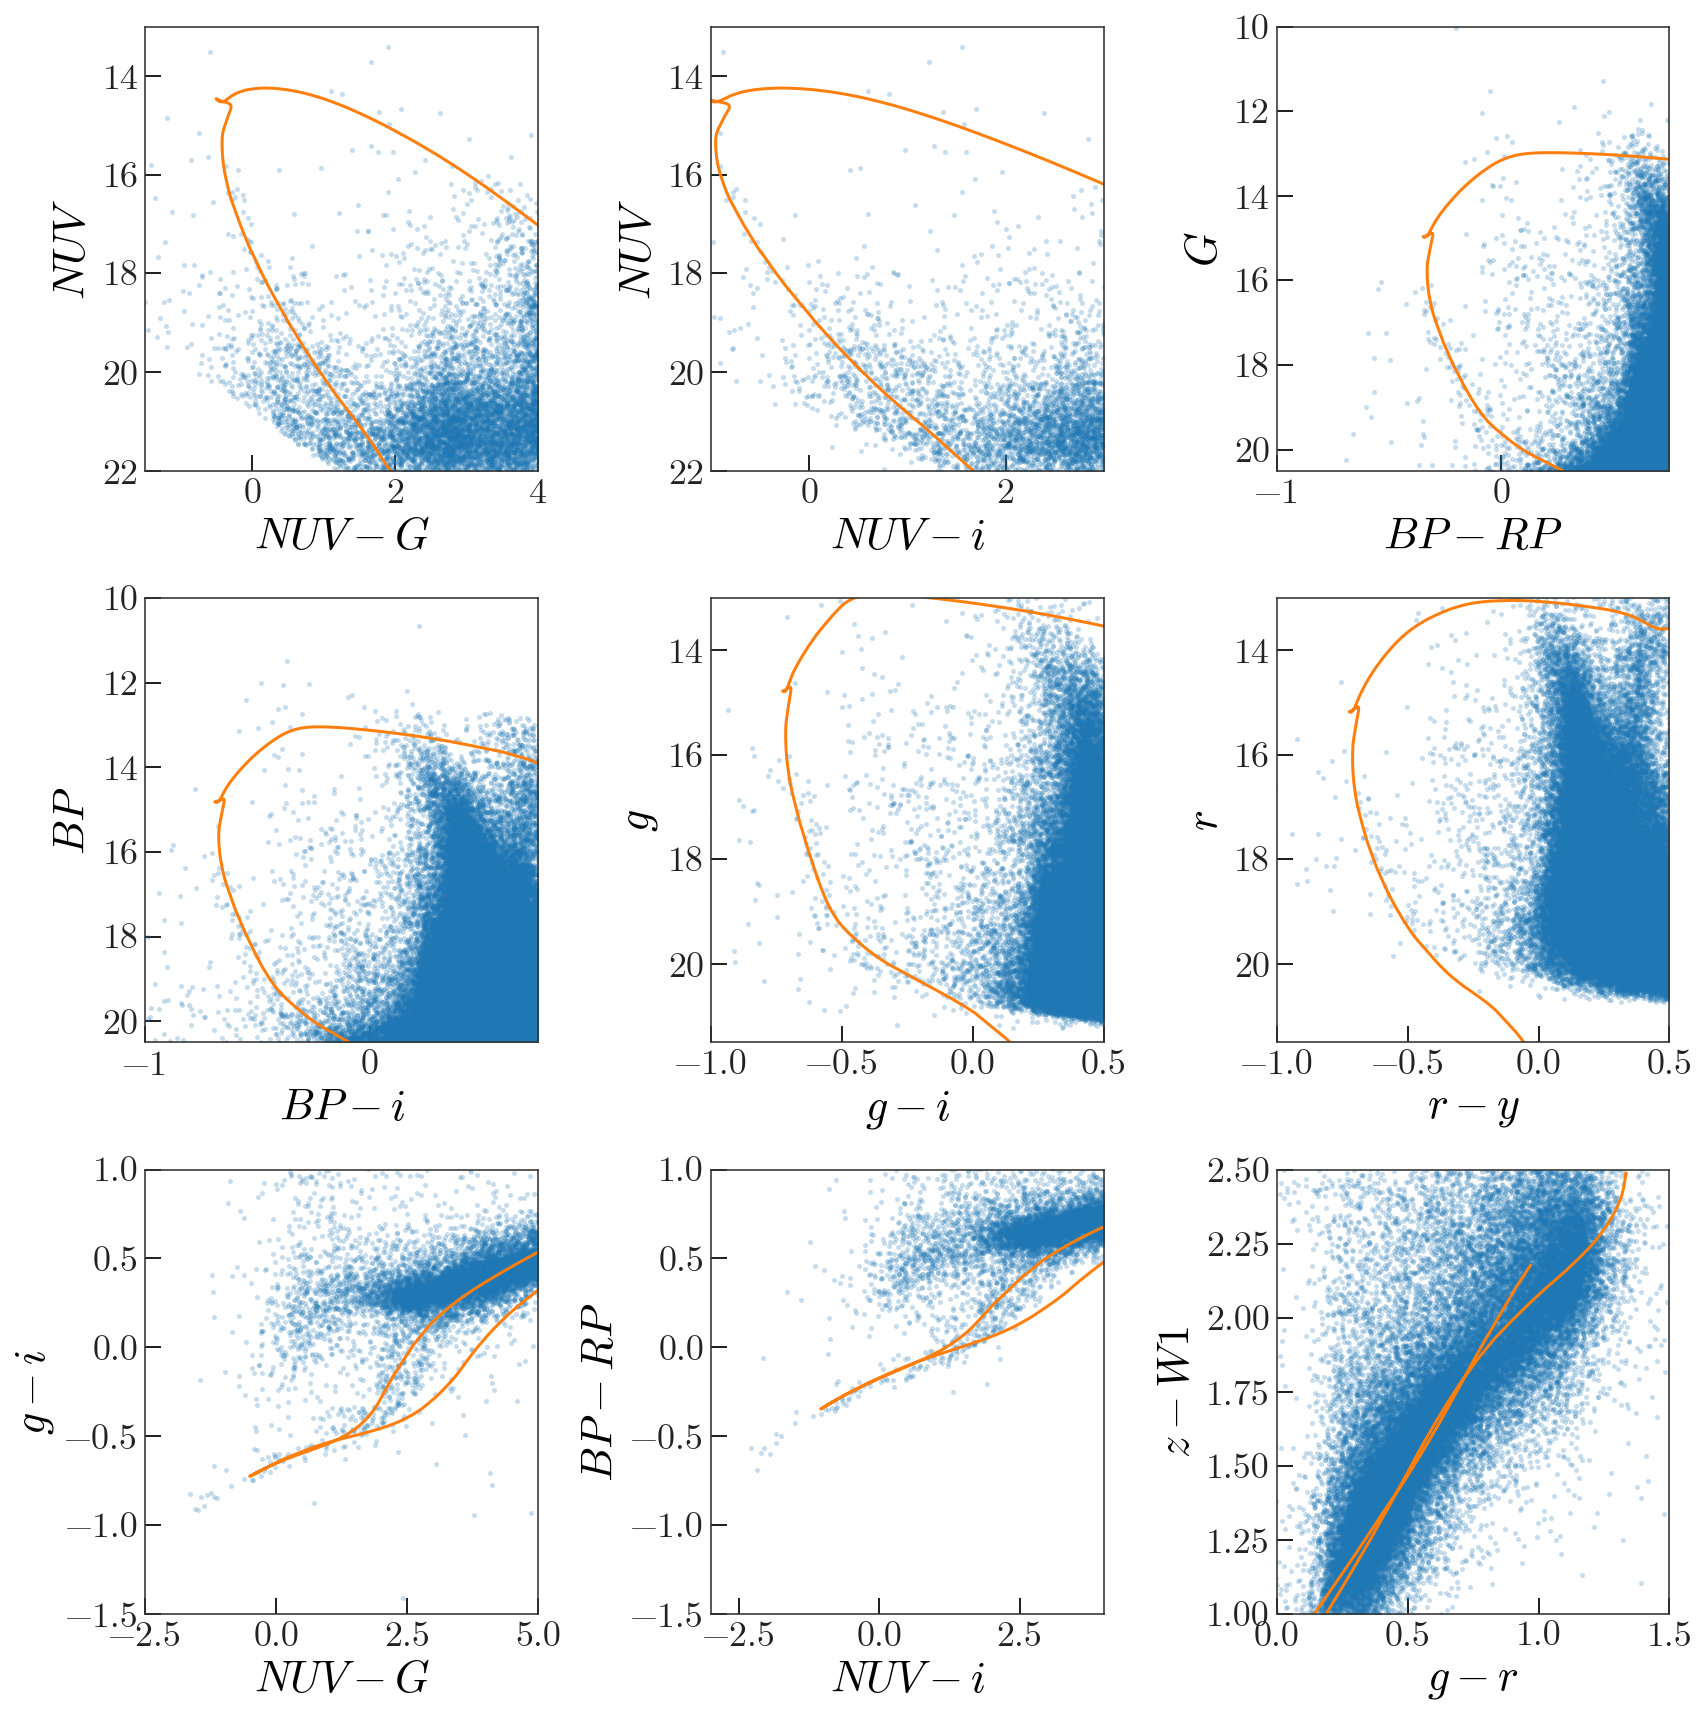

In [13]:
col_mag = [('NUV', 'G', 'NUV'), ('NUV', 'i', 'NUV'), ('BP', 'RP', 'G'),
           ('BP', 'i', 'BP'), ('g', 'i', 'g'), ('r', 'y', 'r'),
           ('NUV', 'G', 'g', 'i'), ('NUV', 'i', 'BP', 'RP'), ('g', 'r', 'z', 'W1')]

xlims = [(-1.5, 4), (-1, 3), (-1., 0.75), 
         (-1, 0.75), (-1, 0.5), (-1, 0.5),
         (-2.5, 5), (-3, 4), (0, 1.5)]
ylims = [(22, 13), (22, 13), (20.5, 10), 
         (20.5, 10), (21.5, 13), (21.5, 13),
         (-1.5, 1), (-1.5, 1), (1, 2.5)]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for k, row in enumerate(col_mag):
    ax = axes.flat[k]
    
    col = phot[row[0]] - phot[row[1]]
    i = iso[np.isclose(iso['isochrone_age_yr'], 5e7) & (iso['phase'] < 3)]
    
    if len(row) == 3:
        mag = phot[row[2]]
        isoy = i[row[2]] + DM
        ylabel = '${0[2]}$'.format(row)
        
    else:
        mag = phot[row[2]] - phot[row[3]]
        isoy = i[row[2]] - i[row[3]]
        ylabel = '${0[2]} - {0[3]}$'.format(row)
    
    ax.plot(col, mag, marker='.', linestyle='none', alpha=0.25)
    ax.plot(i[row[0]] - i[row[1]], isoy, marker='')
    
    ax.set_xlim(xlims[k])
    ax.set_ylim(ylims[k])
    
    ax.set_xlabel('${0[0]} - {0[1]}$'.format(row))
    ax.set_ylabel(ylabel)
    
fig.tight_layout()

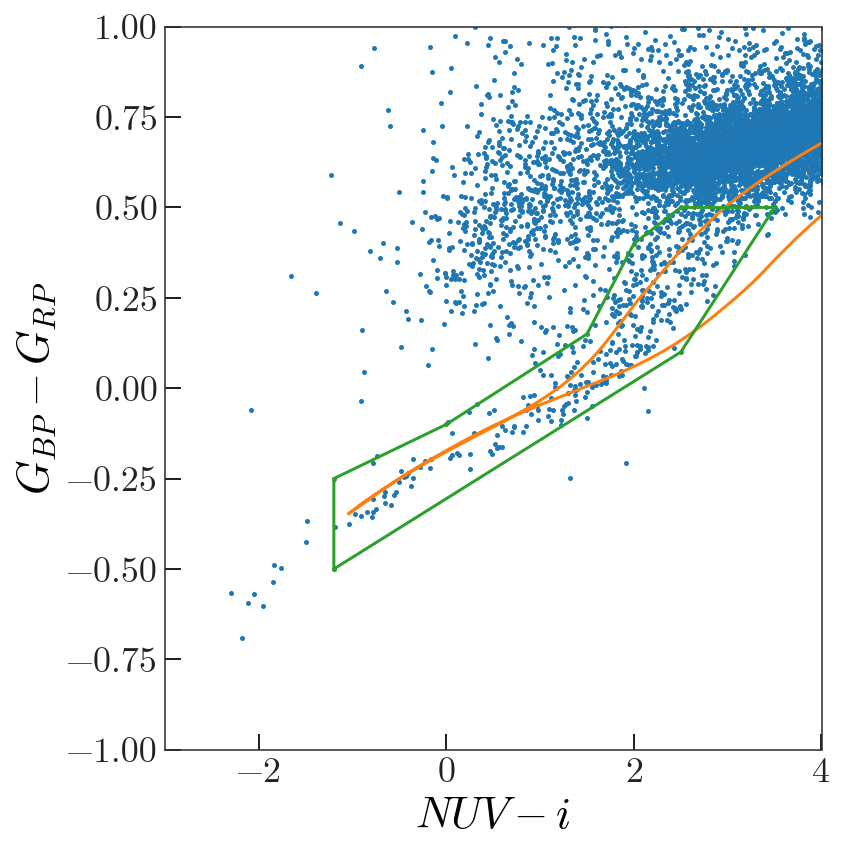

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(phot['NUV']-phot['i'], 
        phot['BP']-phot['RP'],
        marker='.', linestyle='none')

i = iso[np.isclose(iso['isochrone_age_yr'], 5e7) & (iso['phase'] < 3)]
ax.plot(i['NUV']-i['i'], 
        i['BP']-i['RP'], 
        marker='')

nodes = np.array([[-1.2, -0.5],
                  [-1.2, -0.25],
                  [0, -0.1],
                  [1.5, 0.15],
                  [2, 0.4],
                  [2.5, 0.5],
                  [3.5, 0.5],
                  [2.5, 0.1],
                  [-1.2, -0.5]])
cc_path = mpl.patches.Path(nodes[:-1])
ax.plot(nodes[:,0], nodes[:,1])

ax.set_xlim(-3, 4)
ax.set_ylim(-1, 1)

ax.set_xlabel('$NUV - i$')
ax.set_ylabel('$G_{BP} - G_{RP}$')

fig.tight_layout()

fig.savefig('../plots/cmd-NUVi-BPRP.png', dpi=250)

In [15]:
X = np.vstack((phot['NUV']-phot['i'], 
               phot['BP']-phot['RP'])).T
cc_mask = cc_path.contains_points(X)

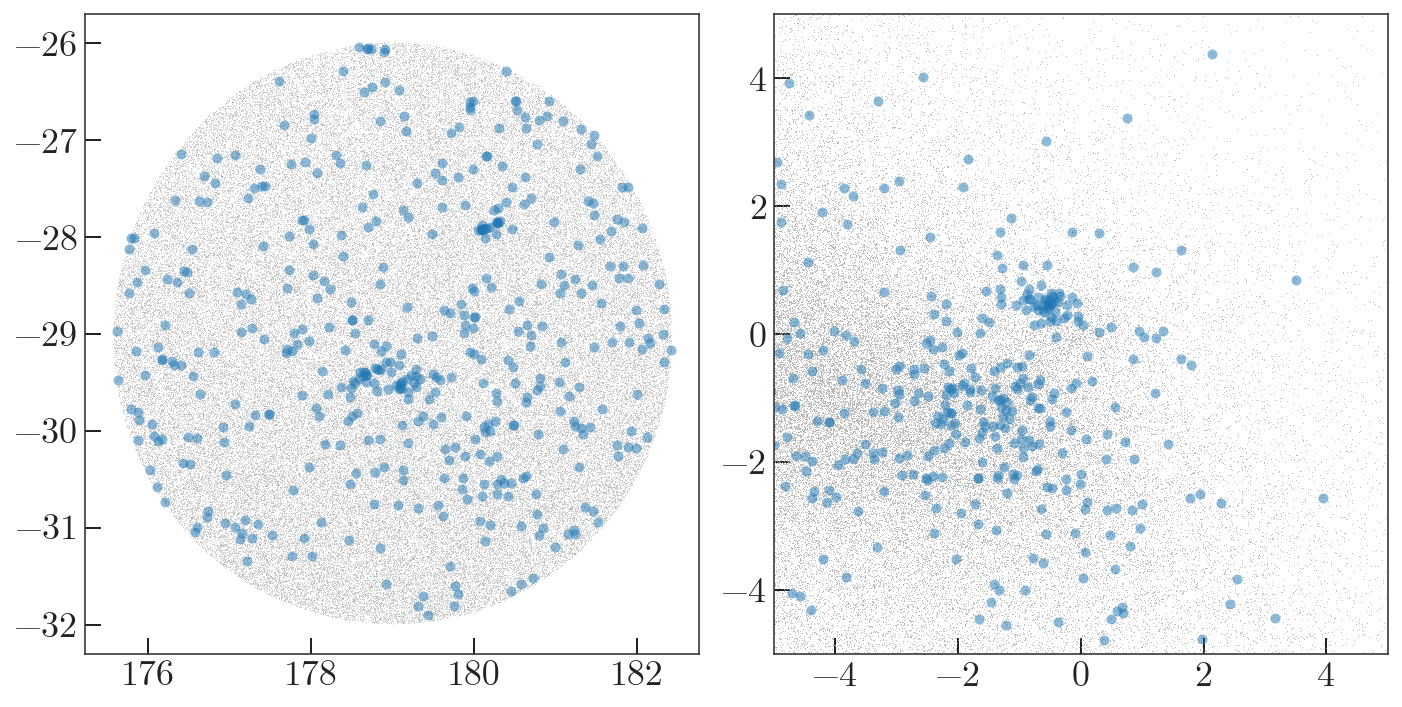

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.plot(g.ra, g.dec, marker=',', color='#aaaaaa', alpha=0.5, linestyle='none')
ax.plot(g.ra[cc_mask], g.dec[cc_mask], 
        marker='o', color='tab:blue', 
        alpha=0.5, linestyle='none')

ax = axes[1]
ax.plot(g.pmra, g.pmdec, marker=',', color='#aaaaaa', alpha=0.75, linestyle='none')
ax.plot(g.pmra[cc_mask], g.pmdec[cc_mask], 
        marker='o', color='tab:blue', 
        alpha=0.5, linestyle='none')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

fig.tight_layout()

## Magellanic stream coordinates:

In [17]:
mag_c = c.transform_to(gc.MagellanicStream)

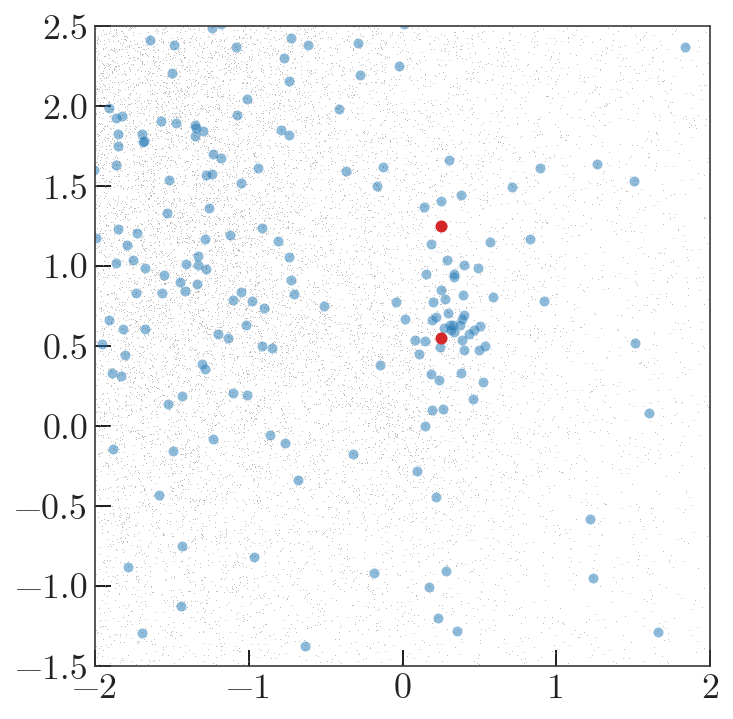

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(mag_c.pm_L_cosB, mag_c.pm_B, marker=',', color='#aaaaaa', alpha=0.75, linestyle='none')
ax.plot(mag_c.pm_L_cosB[cc_mask], mag_c.pm_B[cc_mask], 
        marker='o', color='tab:blue', 
        alpha=0.5, linestyle='none')
ax.set_xlim(-2, 2)
ax.set_ylim(-1.5, 2.5)

ax.scatter(0.25, 0.55, color='tab:red', zorder=100)
ax.scatter(0.25, 0.55+0.7, color='tab:red', zorder=100)

fig.tight_layout()

In [19]:
# pm_mask = np.sqrt((g.pmra - -0.6*u.mas/u.yr)**2 + (g.pmdec - 0.5*u.mas/u.yr)**2) < 0.5*u.mas/u.yr
pm_mask = np.sqrt((mag_c.pm_L_cosB - 0.25*u.mas/u.yr)**2 + (mag_c.pm_B - 0.55*u.mas/u.yr)**2) < 0.7*u.mas/u.yr

(-0.8, 0)

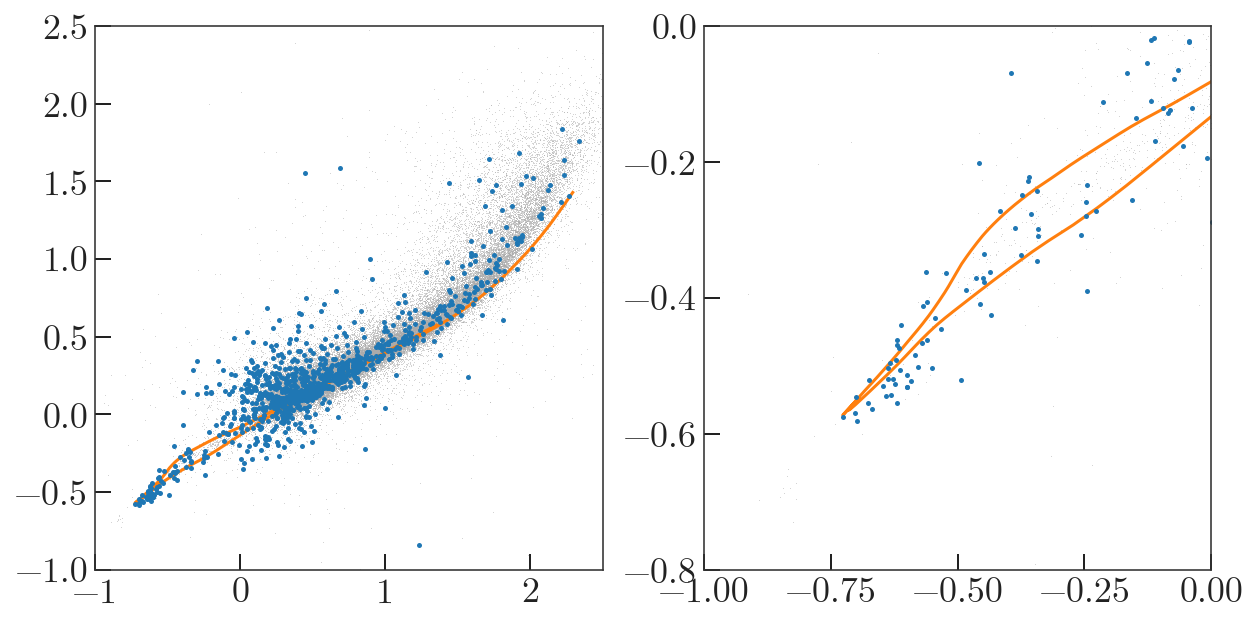

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax in axes:
    ax.plot((phot['g']-phot['i']), 
            (phot['r']-phot['z']),
            marker=',', linestyle='none', 
            alpha=0.5, color='#aaaaaa', zorder=-5)
    ax.plot((phot['g']-phot['i'])[pm_mask], 
            (phot['r']-phot['z'])[pm_mask],
            marker='.', linestyle='none', color='tab:blue')

    i = iso[np.isclose(iso['isochrone_age_yr'], 5e7) & (iso['phase'] < 3)]
    ax.plot(i['g']-i['i'], 
            i['r']-i['z'], 
            marker='', color='tab:orange', zorder=-1)

axes[0].set_xlim(-1, 2.5)
axes[0].set_ylim(-1, 2.5)

axes[1].set_xlim(-1, 0)
axes[1].set_ylim(-0.8, 0)

(-0.5, 2)

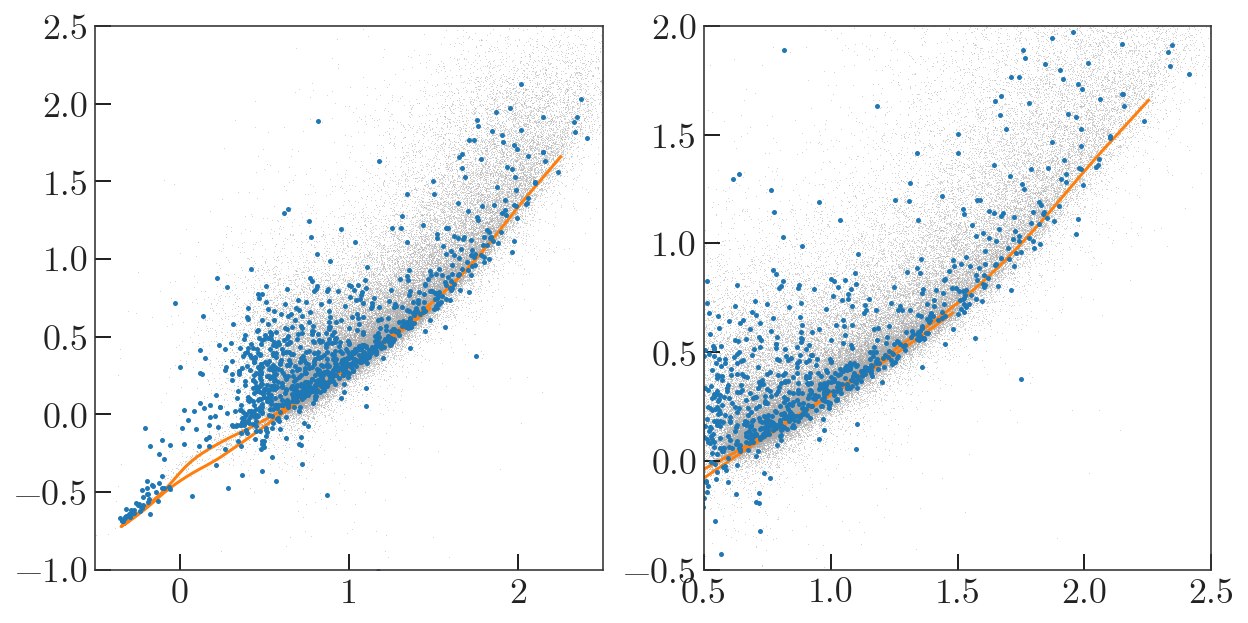

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax in axes:
    ax.plot((phot['BP']-phot['RP']), 
            (phot['r']-phot['y']),
            marker=',', linestyle='none', 
            alpha=0.5, color='#aaaaaa', zorder=-5)
    ax.plot((phot['BP']-phot['RP'])[pm_mask], 
            (phot['r']-phot['y'])[pm_mask],
            marker='.', linestyle='none', color='tab:blue')

    i = iso[np.isclose(iso['isochrone_age_yr'], 5e7) & (iso['phase'] < 3)]
    ax.plot(i['BP']-i['RP'], 
            i['r']-i['y'], 
            marker='', color='tab:orange', zorder=-1)

axes[0].set_xlim(-0.5, 2.5)
axes[0].set_ylim(-1, 2.5)

axes[1].set_xlim(0.5, 2.5)
axes[1].set_ylim(-0.5, 2)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


(1, 2.5)

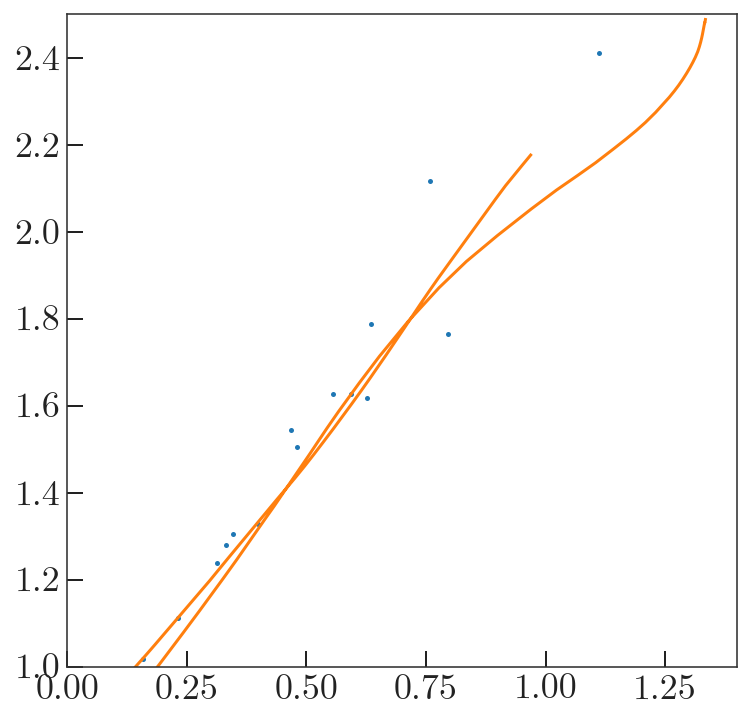

In [22]:
rgb_mask = ((phot['W1'] - phot['W2']) < 0) & (phot['W1'] < 14)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot((phot['g']-phot['r'])[rgb_mask & pm_mask], 
        (phot['z']-phot['W1'])[rgb_mask & pm_mask],
        marker='.', linestyle='none')

i = iso[np.isclose(iso['isochrone_age_yr'], 5e7) & (iso['phase'] < 3)]
ax.plot(i['g']-i['r'], 
        i['z']-i['W1'], 
        marker='')

nodes = np.array([[-1.2, -0.5],
                  [-1.2, -0.25],
                  [0, -0.1],
                  [1.5, 0.15],
                  [2, 0.4],
                  [2.5, 0.5],
                  [3.5, 0.5],
                  [2.5, 0.1],
                  [-1.2, -0.5]])
cc_path = mpl.patches.Path(nodes[:-1])
ax.plot(nodes[:,0], nodes[:,1])

ax.set_xlim(0, 1.4)
ax.set_ylim(1, 2.5)

# ax.set_xlabel('$NUV - i$')
# ax.set_ylabel('$G_{BP} - G_{RP}$')

(-1, 1)

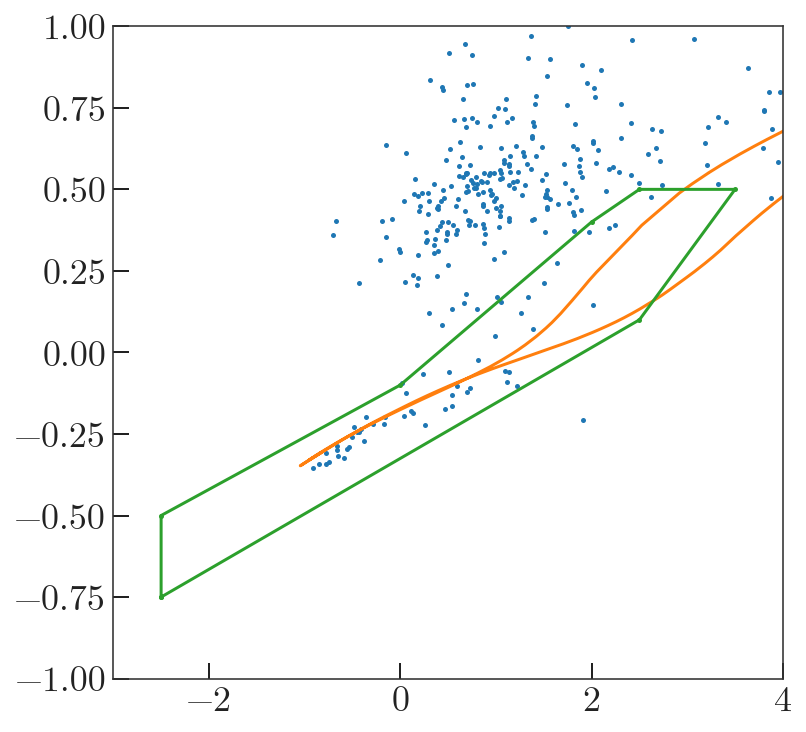

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot((phot['NUV']-phot['i'])[pm_mask], 
        (phot['BP']-phot['RP'])[pm_mask],
        marker='.', linestyle='none')

i = iso[np.isclose(iso['isochrone_age_yr'], 5e7) & (iso['phase'] < 3)]
ax.plot(i['NUV']-i['i'], 
        i['BP']-i['RP'], 
        marker='')

nodes = np.array([[-2.5, -0.75],
                  [-2.5, -0.5],
                  [0, -0.1],
                  [2, 0.4],
                  [2.5, 0.5],
                  [3.5, 0.5],
                  [2.5, 0.1],
                  [-2.5, -0.75]])
cc_path = mpl.patches.Path(nodes[:-1])
ax.plot(nodes[:,0], nodes[:,1])

ax.set_xlim(-3, 4)
ax.set_ylim(-1, 1)

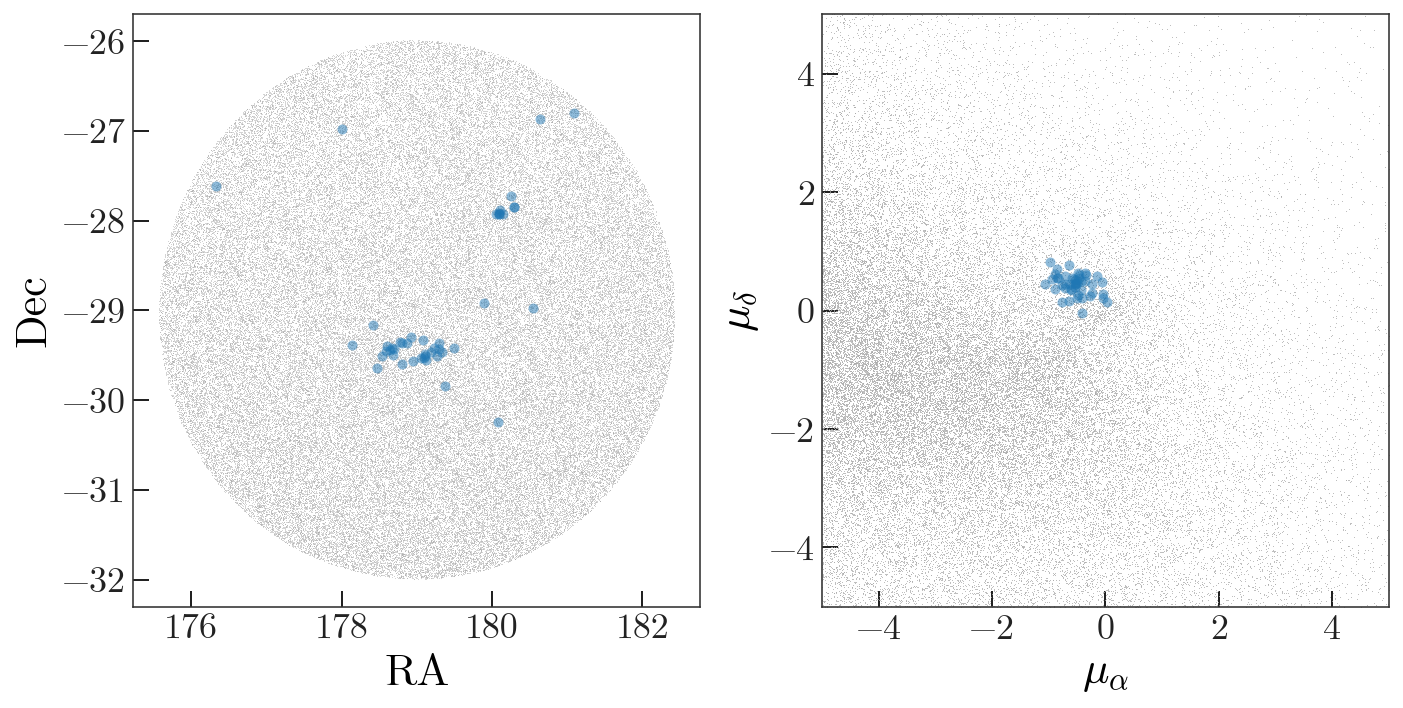

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.plot(g.ra, g.dec, marker=',', color='#aaaaaa', alpha=0.5, linestyle='none')
ax.plot(g.ra[cc_mask & pm_mask], g.dec[cc_mask & pm_mask], 
        marker='o', color='tab:blue', 
        alpha=0.5, linestyle='none')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

ax = axes[1]
ax.plot(g.pmra, g.pmdec, marker=',', color='#aaaaaa', alpha=0.75, linestyle='none')
ax.plot(g.pmra[cc_mask & pm_mask], g.pmdec[cc_mask & pm_mask], 
        marker='o', color='tab:blue', 
        alpha=0.5, linestyle='none')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xlabel(r'$\mu_\alpha$')
ax.set_ylabel(r'$\mu_\delta$')

fig.tight_layout()

fig.savefig('../plots/col-pm-filtered.png', dpi=250)

---

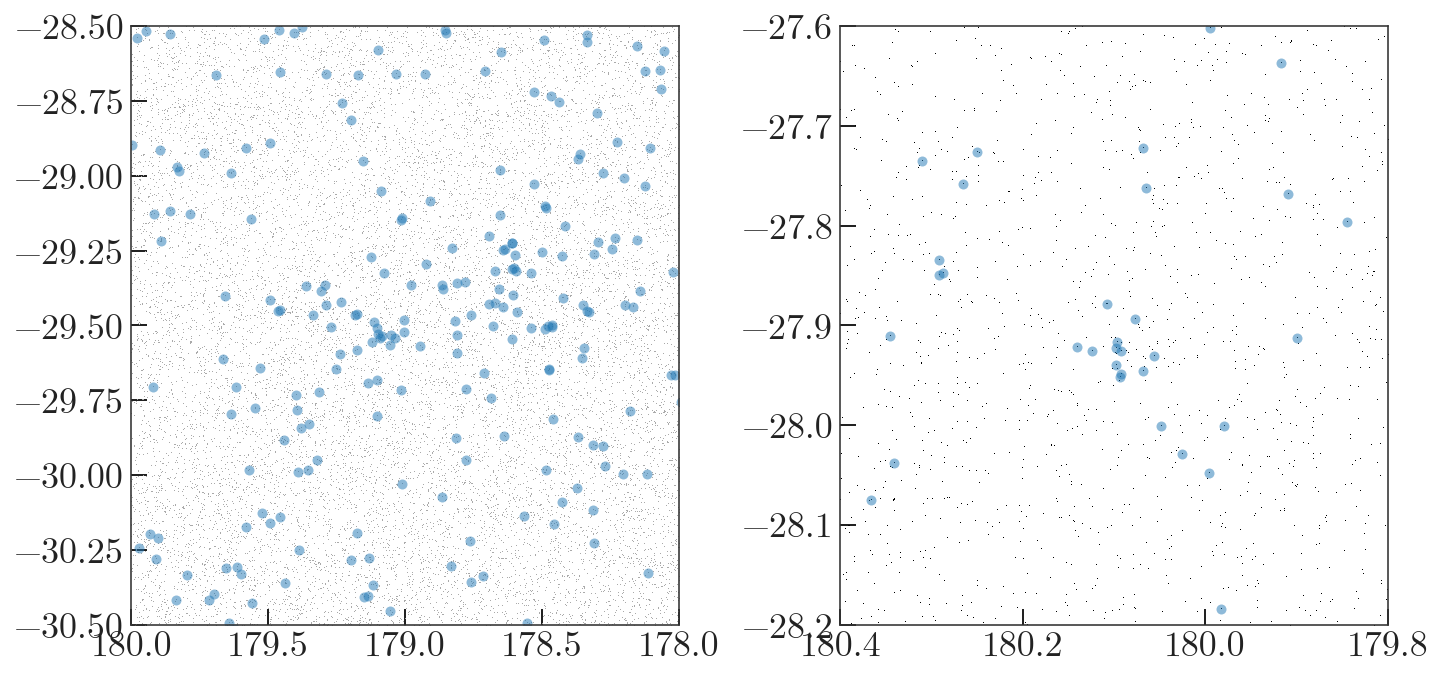

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.8))

ax = axes[0]
ax.plot(g.ra, g.dec, marker=',', color='#aaaaaa', alpha=1, linestyle='none')
ax.plot(g.ra[pm_mask], g.dec[pm_mask], 
        marker='o', color='tab:blue', 
        alpha=0.5, linestyle='none')
ax.set_xlim(180, 178)
ax.set_ylim(-30.5, -28.5)

ax = axes[1]
ax.plot(g.ra, g.dec, marker=',', color='k', alpha=1, linestyle='none')
ax.plot(g.ra[pm_mask], g.dec[pm_mask], 
        marker='o', color='tab:blue', 
        alpha=0.5, linestyle='none')
ax.set_xlim(180.4, 179.8)
ax.set_ylim(-28.2, -27.6)

fig.tight_layout()

In [26]:
(1*u.deg * 30*u.kpc).to(u.pc, u.dimensionless_angles())

<Quantity 523.5987756 pc>

In [28]:
tbl = Table(g.data[pm_mask])

for c in tbl.colnames:
    if tbl[c].dtype == object:
        tbl[c] = np.array(tbl[c], dtype=str)
# tbl.write('../data/pm-masked.fits')

In [29]:
tbl = Table(g.data[pm_mask & cc_mask])

for c in tbl.colnames:
    if tbl[c].dtype == object:
        tbl[c] = np.array(tbl[c], dtype=str)
# tbl.write('../data/cmd-pm-masked.fits')

In [42]:
members = g.get_skycoord(distance=30*u.kpc, radial_velocity=250*u.km/u.s).galactic[pm_mask & cc_mask]

### Integrate orbits

In [51]:
galcen

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in kpc
    [( 5.14140765e-01, -24.07622431, 15.60413452),
     ( 1.55939952e-01, -24.13354465, 15.71361356),
     (-7.42989502e-03, -24.12527337, 15.81323433),
     (-2.14143965e-02, -24.12338394, 15.8234583 ),
     (-2.37281795e-02, -24.1186264 , 15.83193316),
     ( 6.09236634e-02, -24.062638  , 15.87266636),
     ( 4.28617662e-02, -24.08432471, 15.84922152),
     (-4.86114077e-04, -24.0937084 , 15.85773005),
     ( 3.50874657e-02, -24.06506676, 15.88258611),
     ( 1.09831942e-02, -24.07400399, 15.88167187),
     ( 2.16258401e-02, -24.05091697, 15.91110109),
     (-1.23631236e-01, -24.19450174, 15.76783218),
     (-2.45239914e-01, -24.27191976, 15.71124237),
     (-1.94469715e-01, -24.20140006, 15.7938426 ),
     (-2.21985480e-01, -24.19499457, 15.81777669),
     (-2.04298284

In [43]:
mw = gp.MilkyWayPotential()

In [44]:
galcen = members.transform_to(coord.Galactocentric)

In [45]:
w0 = gd.PhaseSpacePosition(galcen.cartesian)

In [46]:
orbits = mw.integrate_orbit(w0, dt=-0.5, n_steps=200)

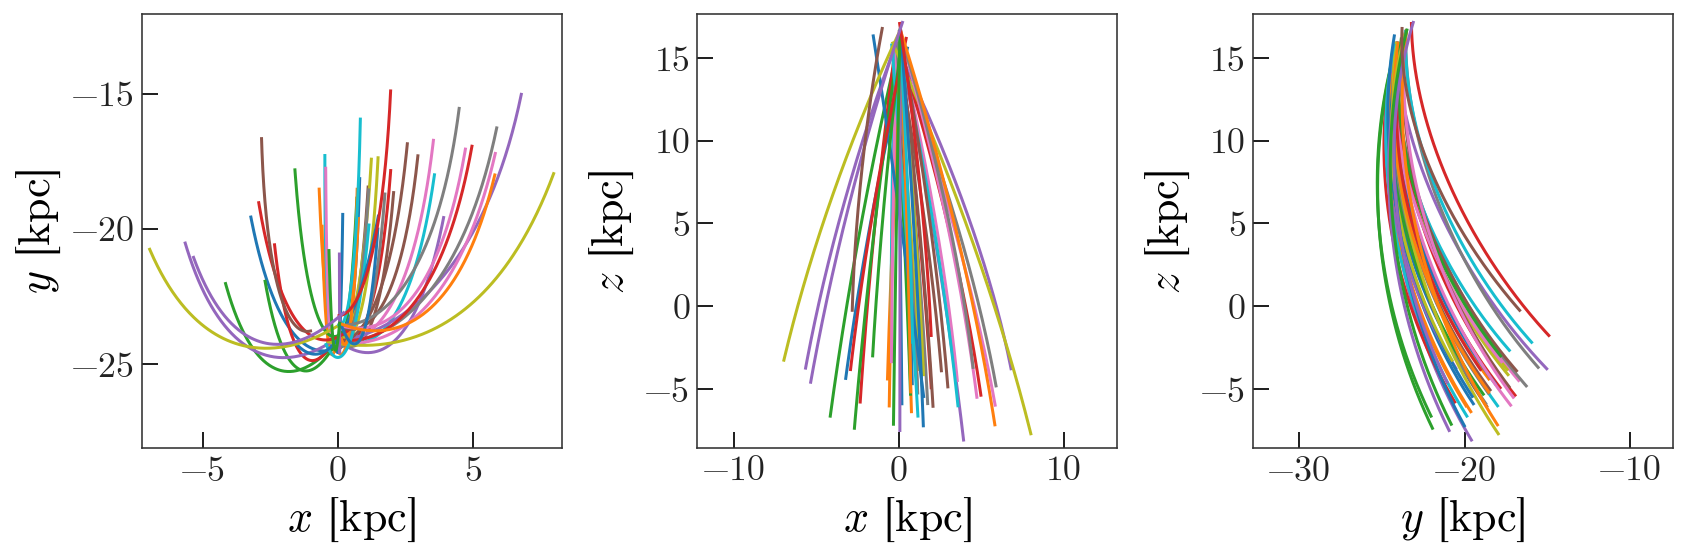

In [48]:
_ = orbits.plot()